# Generate CSV

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [172]:
input_file = './filtered_trulegrowth_rules.txt'
output_csv = './Recommendations/output_csv.csv'
refined_output_csv = './Recommendations/refined_output_csv.csv'
final_rule_data = './Recommendations/final_rule_data.csv'
numberOfRecommendations = 10
recommendations_file = './Recommendations/recommendations.csv'
recommendations_file_labels = './Recommendations/recommendations_final.csv'
path_to_house = '/Users/janhavi/Documents/295B/ukdale/house_2/'
labels_file_path = path_to_house + "labels.dat"
labels_to_name_file = "../Labels_to_name_files/House_2.csv"

In [173]:
show_name_dict = get_display_names_dict(labels_to_name_file)
labels_df, labels_map = get_labels(labels_file_path)

In [174]:
def convert_rule_mining_recs_to_csv(recs_df, show_name_dict):
    recommendation_list = []
    for item in recs_df['Recommendations']:
        recs = []
        item = item[1:-1]
        for channel in item.split(", "):
            channel = channel[2:-2]
            recs.append(channel)
        recommendations = get_appliances_from_channels(recs, labels_df)
        recommendations = change_names(recommendations, show_name_dict)
        recommendation_list.append(",".join(appliance for appliance in recommendations))
    time_recommendation_df = pd.DataFrame({"Time" : time, "Recommendations" : recommendation_list})
    time_recommendation_df.to_csv (recommendations_file_labels, index = False, header=True)

In [175]:
def get_appliances_from_channels(list_of_channels, labels_df):
    """
    This method returns a list of appliance names given a list of channels.
    
    Input:
    list_of_channels = List of channels for which names to be extracted.
    labels_df = Dataframe of channel ids and appliance names.
    
    Output:
    List of appliance names corresponding to each channel in list_of_channels
    """
    result = []
    for item in list_of_channels:
        result.append(labels_df.set_index('Channel_id').at[item, 'Appliance'])
    return result

In [176]:
def change_names(recs, show_name_dict):
    res = []
    for item in recs:
        res.append(show_name_dict[item])
    return res

In [177]:
def get_display_names_dict(labels_to_name_file):
    display_names_dict = dict()
    display_names_df = pd.read_csv(labels_to_name_file, names= ["Labels", "Name"], header = 0)
    for index, row in display_names_df.iterrows():
        display_names_dict[row.Labels] = row.Name
    return display_names_dict

In [178]:
def get_labels(labels_file_path):
    """
    This method gets channel labels from the labels.dat file from the house directory
    
    Input:
    labels_file_path = Path to the labels.dat file.
    
    Output:
    labels_df = Channel and appliance name dataframe.
    labels_dict = Channel and appliance name dictionary.
    """
    labels_df = pd.read_csv(labels_file_path, sep='\\s+', names=['Channel_id', 'Appliance'])
    labels_df["Channel_id"] = ["channel_"+str(i) for i in range(1,labels_df.shape[0]+1)]
    labels_dict = dict()
    for row in labels_df.iterrows():
        labels_dict[row[1]["Channel_id"]] = row[1]["Appliance"]
    return labels_df, labels_dict

In [179]:
# Convert text file of output from TRuleGrowth algorithm into csv with column values as Pattern, Support and COnfidence
read_file = pd.read_csv (input_file, sep=' #', header=None)
read_file.columns = ['Pattern','Support','Confidence']
read_file.to_csv (output_csv, index=None)

In [180]:
# Refine the csv file to replace unwanted strings
my_csv_in = output_csv
my_csv_out = refined_output_csv

with open(my_csv_in, 'r') as f_in:
    with open(my_csv_out, 'w') as f_out:
        for line in f_in:
            f_out.write(line.replace("SUP: ", '').replace("CONF: ", '').replace("0 ==> ", ''))

In [181]:
# Create dataframe for further processing
from pandas.api.types import is_string_dtype
df_csv = pd.read_csv(refined_output_csv)


In [182]:
df_csv

,Pattern,Support,Confidence
0,95300014,83,0.399038
1,11300012,9,0.043269
2,95300015,3,0.014423
3,11300014,86,0.413462
4,11300015,20,0.096154
...,...,...,...
508,19000011,62,0.298077
509,19000013,52,0.250000
510,19000014,96,0.461538
511,19000018,120,0.576923


In [183]:
# Convert Pattern column values to list
pattern_values = df_csv['Pattern'].astype(str).tolist()

In [184]:
'''
Re-manipulate values for patterns
Replace initial 9's with 0's

Special case: When manipulating in input formation for TRuleGrowthAlgorithm, we replaced '0' with '99' instead of '9' in few special cases. For example, 9 am => 09:00:00 => 9990000 instead of 990000 to avoid getting wrong patterns

'''
for x in range(len(pattern_values)):
    rules = pattern_values[x].split(',')
    for j in range(len(rules)):
        if(rules[j].startswith('9990000')): # For 9 am
            rules[j] = rules[j].replace("99", "0", 1)
        elif(rules[j].startswith('9993000')): # For 9:30 am
            rules[j] = rules[j].replace("99", "0", 1)
        else:
            i = 0
            while(rules[j][i] == '9' and i < len(rules[j])-1 ):
                i = i + 1
            rules[j] = rules[j].replace("9", "0", i)
    pattern_values[x] = rules

In [185]:
''' 
1] Cponvert the patterns in time_channel format by performing string manipulation
2] Add a column for 'Time' for convenience - Set as 'NaN' of the patterns in same row are not of the same time
'''

time = []
previous_times = []
for listitem in pattern_values:
  for i in range(len(listitem)):
    listitem[i] = listitem[i][:2] + ':' + listitem[i][2:4] + ':' + listitem[i][4:6] + ' channel_' + listitem[i][6:]
    previous_times.append(listitem[i][:8])
  if(len(set(previous_times)) == 1):
    time.append(previous_times[0])
  else:
    time.append('NaN')
  previous_times = []
df_csv['Pattern'] = pattern_values
df_csv['Time'] = time

In [186]:
# Print dataframe
df_csv

,Pattern,Support,Confidence,Time
0,[05:30:00 channel_14],83,0.399038,05:30:00
1,[11:30:00 channel_12],9,0.043269,11:30:00
2,[05:30:00 channel_15],3,0.014423,05:30:00
3,[11:30:00 channel_14],86,0.413462,11:30:00
4,[11:30:00 channel_15],20,0.096154,11:30:00
...,...,...,...,...
508,[19:00:00 channel_11],62,0.298077,19:00:00
509,[19:00:00 channel_13],52,0.250000,19:00:00
510,[19:00:00 channel_14],96,0.461538,19:00:00
511,[19:00:00 channel_18],120,0.576923,19:00:00


In [187]:
# Filter out rows having 'NaN' as Time values from dataframe
df_csv = df_csv.loc[df_csv['Time'] != 'NaN']

## Export final csv

In [188]:
# Generate final csv consisting of cleaned and relevant values to be used in further processing
df_csv.to_csv (final_rules_data, index = False, header=True)
df_csv

NameError: name 'final_rules_data' is not defined

## Graphs for sample times

In [189]:
# Sample graph depicting confidence levels according to channels at 12:30 am
df_csv_00_30 = df_csv.loc[df_csv['Time'] == '00:30:00']
df_csv_00_30

,Pattern,Support,Confidence,Time
156,[00:30:00 channel_7],31,0.149038,00:30:00
158,[00:30:00 channel_6],54,0.259615,00:30:00
160,[00:30:00 channel_5],36,0.173077,00:30:00
162,[00:30:00 channel_4],44,0.211538,00:30:00
163,[00:30:00 channel_3],34,0.163462,00:30:00
164,[00:30:00 channel_2],37,0.177885,00:30:00
426,[00:30:00 channel_14],79,0.379808,00:30:00
444,[00:30:00 channel_18],120,0.576923,00:30:00


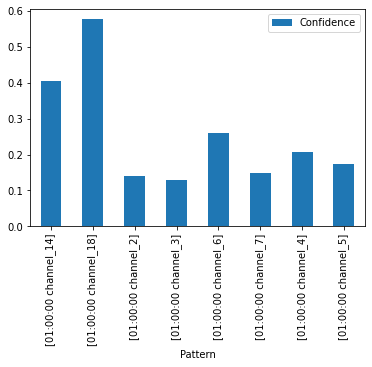

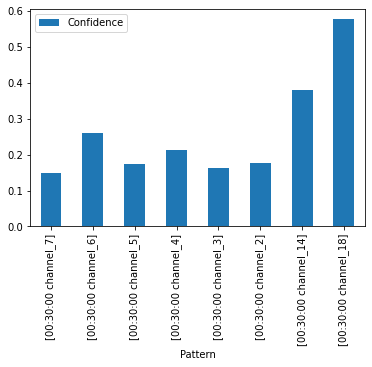

In [190]:
# Sample graph depicting confidence levels according to channels at 1:00 am
df_csv_01 = df_csv.loc[df_csv['Time'] == '01:00:00']
df_csv_01.plot(kind='bar',x='Pattern',y='Confidence')
df_csv_00_30.plot(kind='bar',x='Pattern',y='Confidence')

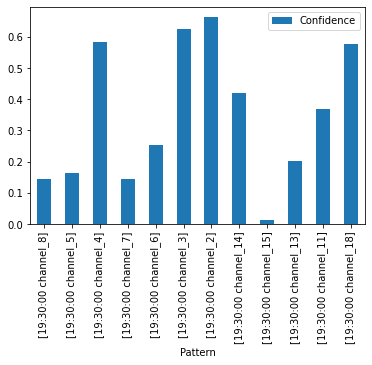

In [191]:
# Sample graph depicting confidence levels according to channels at 1:00 am
df_csv_19_30 = df_csv.loc[df_csv['Time'] == '19:30:00']
df_csv_19_30.plot(kind='bar',x='Pattern',y='Confidence')

## Generate Recommendations
### Input: Time of the day

In [192]:
# Function to generate recommendations
# Input: time_of_the_day = Time of the day and Num = Number of recommendations to be generated
# Output: Pattern list
def generate_recommendation(time_of_the_day, num):
    '''
        This function generates the recommendations
        Input: 
            time_of_the_day = Time of the day 
            num = Number of recommendations to be generated
        Output: 
            pattern list = list of appliances ON at a particular time
    '''
    recommendations = []
    df = df_csv.loc[df_csv['Time'] == time_of_the_day]
    print(df)
    pattern_list = df.nlargest(num, 'Confidence')['Pattern'].tolist()
    for pattern in pattern_list:
        for i in range(len(pattern)):
            pattern[i] = pattern[i].split(' ')[1]
    return pattern_list

In [193]:
# 48 instances of time
time = ['00:00:00', '00:30:00', '01:00:00', '01:30:00', '02:00:00', '02:30:00','03:00:00', '03:30:00', '04:00:00', '04:30:00','05:00:00', '05:30:00','06:00:00', '06:30:00','07:00:00', '07:30:00','08:00:00', '08:30:00','09:00:00', '09:30:00','10:00:00', '10:30:00','11:00:00', '11:30:00','12:00:00', '12:30:00','13:00:00', '13:30:00','14:00:00', '14:30:00', '15:00:00', '15:30:00','16:00:00', '16:30:00','17:00:00', '17:30:00','18:00:00', '18:30:00','19:00:00', '19:30:00','20:00:00', '20:30:00','21:00:00', '21:30:00','22:00:00', '22:30:00','23:00:00', '23:30:00']


In [194]:
# Get dataframe with channel 4, 5 and 6(always on) considered
dfObj = pd.DataFrame(columns=['Time', 'Recommendations'])
for i in time:
    recommendations = generate_recommendation(i, numberOfRecommendations)
    dfObj = dfObj.append({'Time': i, 'Recommendations': recommendations}, ignore_index=True)
print("Dataframe Contents ", dfObj, sep='\n')

el_3]      102    0.490385  12:30:00
83    [12:30:00 channel_6]       52    0.250000  12:30:00
84    [12:30:00 channel_7]       31    0.149038  12:30:00
85    [12:30:00 channel_4]       94    0.451923  12:30:00
86    [12:30:00 channel_5]       36    0.173077  12:30:00
90    [12:30:00 channel_8]       13    0.062500  12:30:00
318  [12:30:00 channel_18]      119    0.572115  12:30:00
327  [12:30:00 channel_11]       25    0.120192  12:30:00
329  [12:30:00 channel_15]       12    0.057692  12:30:00
330  [12:30:00 channel_14]       85    0.408654  12:30:00
332  [12:30:00 channel_12]        5    0.024038  12:30:00
                   Pattern  Support  Confidence      Time
165  [13:00:00 channel_14]       83    0.399038  13:00:00
166  [13:00:00 channel_15]        3    0.014423  13:00:00
167  [13:00:00 channel_11]       27    0.129808  13:00:00
168  [13:00:00 channel_18]      120    0.576923  13:00:00
293   [13:00:00 channel_3]      104    0.500000  13:00:00
295   [13:00:00 channel_2]      105

In [195]:
# Generate csv for recommendations
dfObj.to_csv (recommendations_file, index = False, header=True)

In [196]:
recs_df = pd.read_csv(recommendations_file, header=0)

In [197]:
recs_df

,Time,Recommendations
0,00:00:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
1,00:30:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
2,01:00:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
3,01:30:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
4,02:00:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
5,02:30:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
6,03:00:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
7,03:30:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
8,04:00:00,"[['channel_18'], ['channel_14'], ['channel_6']..."
9,04:30:00,"[['channel_18'], ['channel_14'], ['channel_6']..."


In [198]:
convert_rule_mining_recs_to_csv(recs_df, show_name_dict)